# Bibliotecas

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# Baixandos os dados do dataset AmesHousing

In [5]:
# carregar base de dados
file_path = 'AmesHousing.csv'
housing_data = pd.read_csv(file_path)

# verficar 5 primeiras linhas
housing_data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [38]:
print(housing_data.describe())

            Order           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2930.00000  2.930000e+03  2930.000000   2440.000000    2930.000000   
mean   1465.50000  7.144645e+08    57.387372     69.224590   10147.921843   
std     845.96247  1.887308e+08    42.638025     23.365335    7880.017759   
min       1.00000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     733.25000  5.284770e+08    20.000000     58.000000    7440.250000   
50%    1465.50000  5.354536e+08    50.000000     68.000000    9436.500000   
75%    2197.75000  9.071811e+08    70.000000     80.000000   11555.250000   
max    2930.00000  1.007100e+09   190.000000    313.000000  215245.000000   

       Overall Qual  Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  \
count   2930.000000   2930.000000  2930.000000     2930.000000   2907.000000   
mean       6.094881      5.563140  1971.356314     1984.266553    101.896801   
std        1.411026      1.111537    30.245361       20.860286    

In [6]:
# Criar um LabelEncoder
label_encoder = LabelEncoder()

# Aplicar para todas as colunas categóricas
for col in housing_data.select_dtypes(include=['object']).columns:
    housing_data[col] = label_encoder.fit_transform(housing_data[col])

#print(housing_data.head())

## Matriz de correlação

In [7]:
correlation_matrix = housing_data.corr()
print(correlation_matrix['SalePrice'].sort_values(ascending=False))

SalePrice        1.000000
Overall Qual     0.799262
Gr Liv Area      0.706780
Garage Cars      0.647877
Garage Area      0.640401
                   ...   
Fireplace Qu    -0.474762
Garage Finish   -0.549899
Kitchen Qual    -0.613689
Bsmt Qual       -0.619841
Exter Qual      -0.647616
Name: SalePrice, Length: 82, dtype: float64


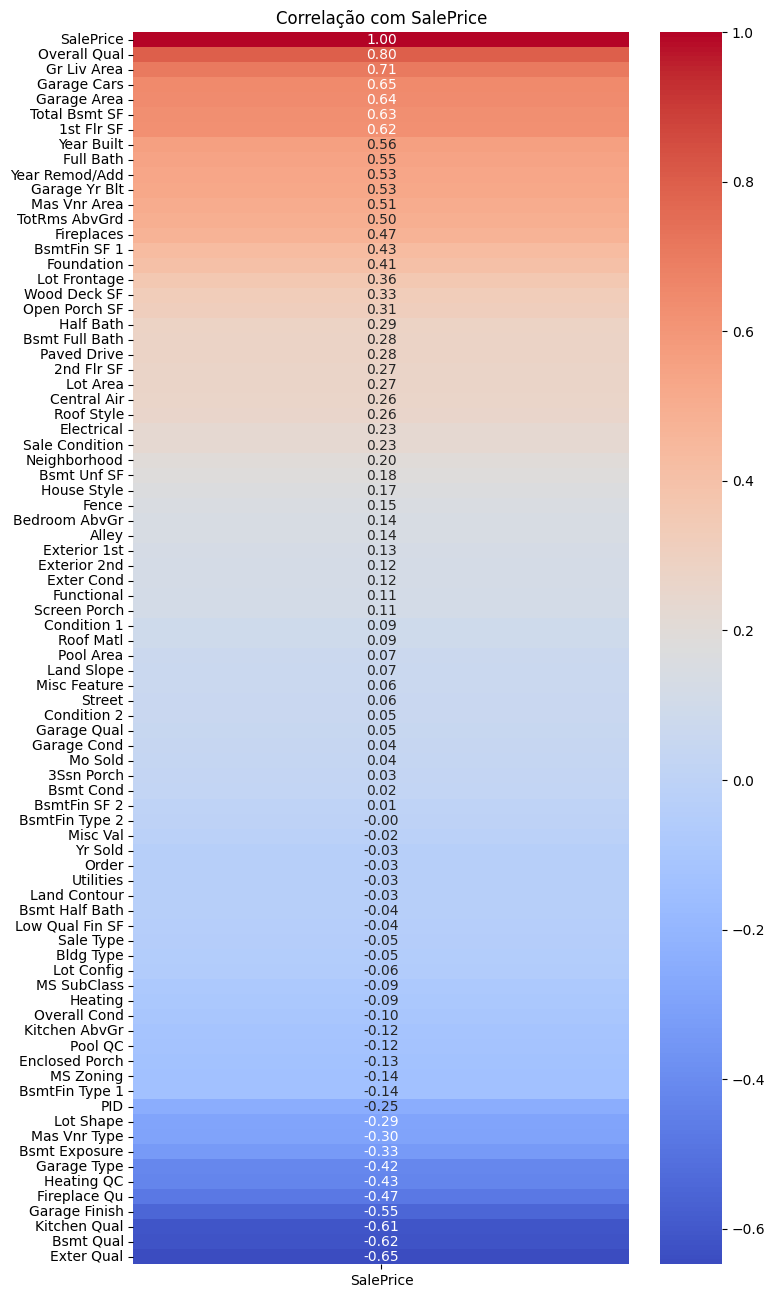

In [46]:
# Focar apenas nas correlações com SalePrice
saleprice_corr = correlation_matrix[['SalePrice']].sort_values(by='SalePrice', ascending=False)

# Plotar o heatmap
plt.figure(figsize=(8, 16))
sns.heatmap(saleprice_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlação com SalePrice')
plt.show()

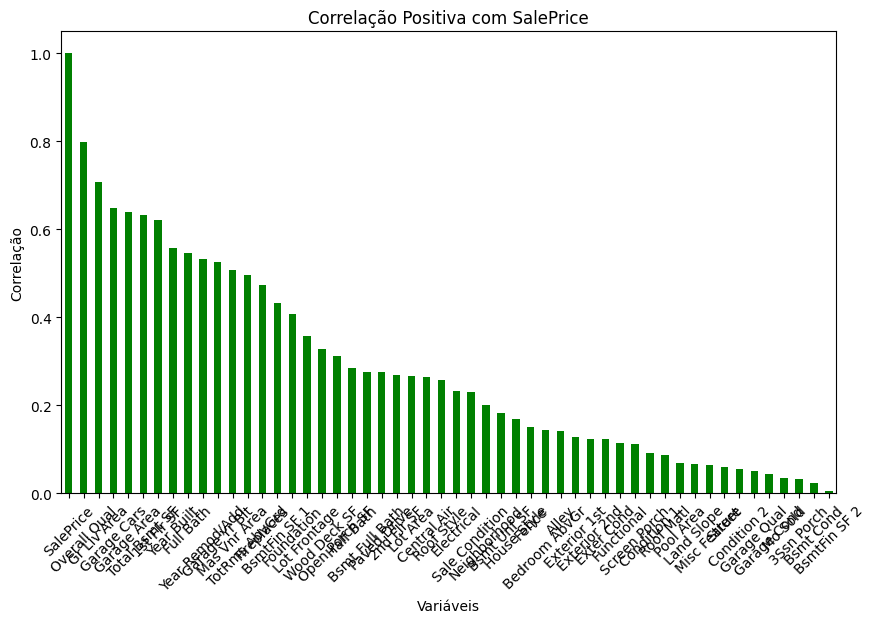

In [10]:
# Selecionar correlações positivas com SalePrice
positive_corr = correlation_matrix['SalePrice'][correlation_matrix['SalePrice'] > 0].sort_values(ascending=False)

# Plotar as correlações positivas
plt.figure(figsize=(10, 6))
positive_corr.plot(kind='bar', color='green')
plt.title('Correlação Positiva com SalePrice')
plt.xlabel('Variáveis')
plt.ylabel('Correlação')
plt.xticks(rotation=45)
plt.show()

## Modelo de Regressão Linear c/ 9 variáveis

In [62]:
selected_features = correlation_matrix['SalePrice'][abs(correlation_matrix['SalePrice']) > 0.6]
print(selected_features.sort_values(ascending=False))

SalePrice        1.000000
Overall Qual     0.799262
Gr Liv Area      0.706780
Garage Cars      0.647877
Garage Area      0.640401
Total Bsmt SF    0.632280
1st Flr SF       0.621676
Kitchen Qual    -0.613689
Bsmt Qual       -0.619841
Exter Qual      -0.647616
Name: SalePrice, dtype: float64


In [121]:
# Separar as variáveis independentes (x) e dependentes (y)

X = housing_data[['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Kitchen Qual', 'Bsmt Qual', 'Exter Qual']]
y = housing_data['SalePrice']

In [122]:
# Excluir linhas com valores NaN
X = X.dropna()
y = y.loc[X.index]  # Garantir que `y` esteja alinhado com o novo `X`

In [124]:
# Identificar as variáveis categóricas
categorical_columns = ['Overall Qual', 'Kitchen Qual', 'Bsmt Qual', 'Exter Qual']

# Aplicar Label Encoding
label_encoder = LabelEncoder()
for col in categorical_columns:
    X.loc[:, col] = label_encoder.fit_transform(X[col])

In [125]:
#Divisão dataset treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
# Criar e treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [127]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calcular métricas
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.81
RMSE: 39201.01
MAE: 23265.10


## Modelo de Regressão Linear c/ 15 variáveis

In [11]:
selected_features = correlation_matrix['SalePrice'][abs(correlation_matrix['SalePrice']) > 0.5]
print(selected_features.sort_values(ascending=False))

SalePrice         1.000000
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Garage Yr Blt     0.526965
Mas Vnr Area      0.508285
Garage Finish    -0.549899
Kitchen Qual     -0.613689
Bsmt Qual        -0.619841
Exter Qual       -0.647616
Name: SalePrice, dtype: float64


In [12]:
# Separar as variáveis independentes (x) e dependentes (y)

X = housing_data[['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 
                  'Year Built', 'Full Bath', 'Year Remod/Add', 'Garage Yr Blt', 'Mas Vnr Area', 'Garage Finish',
                  'Kitchen Qual', 'Bsmt Qual', 'Exter Qual']]
y = housing_data['SalePrice']

In [42]:
# Excluir linhas com valores NaN
X = X.dropna()
y = y.loc[X.index]  # Garantir que `y` esteja alinhado com o novo `X`

print("len(X): ", len(X))

len(X):  2274


In [14]:
# Identificar as variáveis categóricas
categorical_columns = ['Overall Qual', 'Kitchen Qual', 'Bsmt Qual', 'Exter Qual']

# Aplicar Label Encoding
label_encoder = LabelEncoder()
for col in categorical_columns:
    X.loc[:, col] = label_encoder.fit_transform(X[col])

In [15]:
#Divisão dataset treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [16]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calcular métricas
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.84
RMSE: 32512.84
MAE: 22872.63


## Modelo de Regressão Linear c/ 22 variáveis

In [17]:
selected_features = correlation_matrix['SalePrice'][abs(correlation_matrix['SalePrice']) > 0.4]
print(selected_features.sort_values(ascending=False))

SalePrice         1.000000
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Garage Yr Blt     0.526965
Mas Vnr Area      0.508285
TotRms AbvGrd     0.495474
Fireplaces        0.474558
BsmtFin SF 1      0.432914
Foundation        0.406601
Garage Type      -0.418177
Heating QC       -0.425473
Fireplace Qu     -0.474762
Garage Finish    -0.549899
Kitchen Qual     -0.613689
Bsmt Qual        -0.619841
Exter Qual       -0.647616
Name: SalePrice, dtype: float64


In [43]:
# Separar as variáveis independentes (x) e dependentes (y)
X = housing_data[['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 
                  'Year Built', 'Full Bath', 'Year Remod/Add', 'Garage Yr Blt', 'Mas Vnr Area', 'TotRms AbvGrd',
                  'Fireplaces', 'BsmtFin SF 1', 'Foundation', 'Garage Type', 'Heating QC', 'Fireplace Qu', 
                  'Garage Finish', 'Kitchen Qual', 'Bsmt Qual', 'Exter Qual']]
y = housing_data['SalePrice']

# Excluir linhas com valores NaN
X = X.dropna()
y = y.loc[X.index]  # Garantir que `y` esteja alinhado com o novo `X`
print("len(X): ", len(X))

len(X):  2748


In [21]:
# Identificar as variáveis categóricas
categorical_columns = ['Overall Qual', 'Kitchen Qual', 'Bsmt Qual', 'Exter Qual']

# Aplicar Label Encoding
label_encoder = LabelEncoder()
for col in categorical_columns:
    X.loc[:, col] = label_encoder.fit_transform(X[col])

In [22]:
#Divisão dataset treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [23]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calcular métricas
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.86
RMSE: 30669.99
MAE: 21227.49


## Modelo de Regressão Linear c/ 55 variáveis

In [40]:
selected_features = correlation_matrix['SalePrice'][abs(correlation_matrix['SalePrice']) > 0.1]
print(selected_features.sort_values(ascending=False))

print()
series_indices = selected_features.sort_values(ascending=False).index.tolist()
print(series_indices)

SalePrice         1.000000
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Garage Yr Blt     0.526965
Mas Vnr Area      0.508285
TotRms AbvGrd     0.495474
Fireplaces        0.474558
BsmtFin SF 1      0.432914
Foundation        0.406601
Lot Frontage      0.357318
Wood Deck SF      0.327143
Open Porch SF     0.312951
Half Bath         0.285056
Bsmt Full Bath    0.276050
Paved Drive       0.275964
2nd Flr SF        0.269373
Lot Area          0.266549
Central Air       0.264506
Roof Style        0.257170
Electrical        0.232197
Sale Condition    0.230125
Neighborhood      0.200238
Bsmt Unf SF       0.182855
House Style       0.167986
Fence             0.150889
Bedroom AbvGr     0.143913
Alley             0.141909
Exterior 1st      0.127041
Exterior 2nd      0.124436
Exter Cond        0.122877
F

In [44]:
# Separar as variáveis independentes (x) e dependentes (y)
X = housing_data[['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area', 'Total Bsmt SF', '1st Flr SF',
                  'Year Built', 'Full Bath', 'Year Remod/Add', 'Garage Yr Blt', 'Mas Vnr Area', 'TotRms AbvGrd', 'Fireplaces', 
                  'BsmtFin SF 1', 'Foundation', 'Lot Frontage', 'Wood Deck SF', 'Open Porch SF', 'Half Bath', 'Bsmt Full Bath', 
                  'Paved Drive', '2nd Flr SF', 'Lot Area', 'Central Air', 'Roof Style', 'Electrical', 'Sale Condition', 
                  'Neighborhood', 'Bsmt Unf SF', 'House Style', 'Fence', 'Bedroom AbvGr', 'Alley', 'Exterior 1st', 'Exterior 2nd', 
                  'Exter Cond', 'Functional', 'Screen Porch', 'Overall Cond', 'Kitchen AbvGr', 'Pool QC', 'Enclosed Porch', 
                  'MS Zoning', 'BsmtFin Type 1', 'PID', 'Lot Shape', 'Mas Vnr Type', 'Bsmt Exposure', 'Garage Type', 'Heating QC', 
                  'Fireplace Qu', 'Garage Finish', 'Kitchen Qual', 'Bsmt Qual', 'Exter Qual']]
y = housing_data['SalePrice']

# Excluir linhas com valores NaN
X = X.dropna()
y = y.loc[X.index]  # Garantir que `y` esteja alinhado com o novo `X`

print("len(X): ", len(X))

len(X):  2274


In [35]:
# Identificar as variáveis categóricas
categorical_columns = ['Overall Qual', 'Kitchen Qual', 'Bsmt Qual', 'Exter Qual']

# Aplicar Label Encoding
label_encoder = LabelEncoder()
for col in categorical_columns:
    X.loc[:, col] = label_encoder.fit_transform(X[col])

In [37]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calcular métricas
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.82
RMSE: 34804.54
MAE: 19460.16


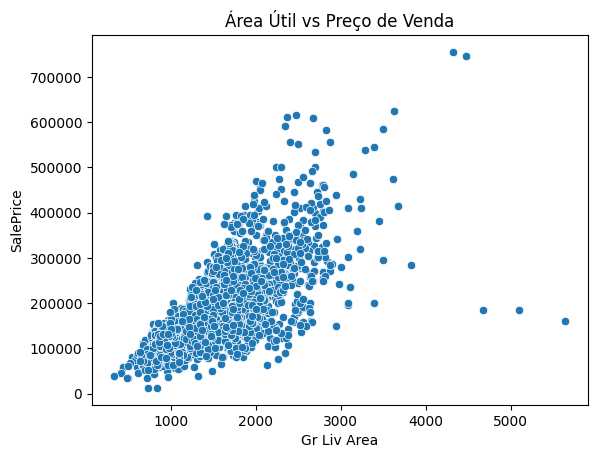

In [44]:
sns.scatterplot(x='Gr Liv Area', y='SalePrice', data=housing_data)
plt.title('Área Útil vs Preço de Venda')
plt.show()

In [36]:
#Divisão dataset treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

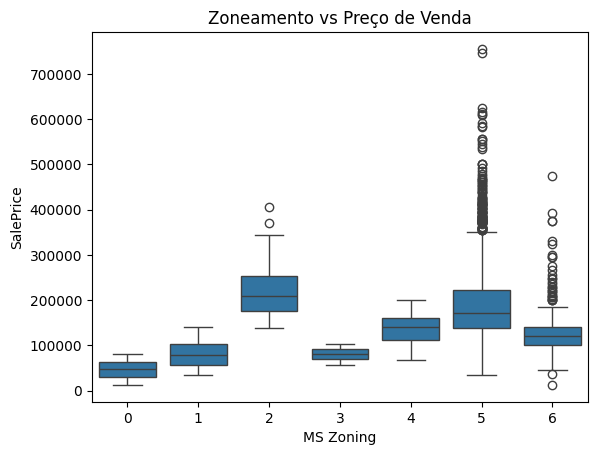

In [45]:
sns.boxplot(x='MS Zoning', y='SalePrice', data=housing_data)
plt.title('Zoneamento vs Preço de Venda')
plt.show()

In [13]:
# Garantir que não haja valores ausentes nas colunas analisadas
filtered_data = housing_data[['Bedroom AbvGr', 'MS Zoning', 'Overall Cond', 'SalePrice']].dropna()

In [14]:
# Visualizar estatísticas descritivas
print("\nResumo estatístico:")
print(filtered_data[['Bedroom AbvGr', 'Overall Cond', 'SalePrice']].describe())


Resumo estatístico:
       Bedroom AbvGr  Overall Cond      SalePrice
count    2930.000000   2930.000000    2930.000000
mean        2.854266      5.563140  180796.060068
std         0.827731      1.111537   79886.692357
min         0.000000      1.000000   12789.000000
25%         2.000000      5.000000  129500.000000
50%         3.000000      5.000000  160000.000000
75%         3.000000      6.000000  213500.000000
max         8.000000      9.000000  755000.000000


In [19]:
# Separar as variáveis independentes (x) e dependentes (y)

X = filtered_data[['Bedroom AbvGr', 'MS Zoning', 'Overall Cond']]
y = filtered_data['SalePrice']

In [20]:
# Codificar variáveis categóricas (MS Zoning) com OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['MS Zoning'])
    ],
    remainder='passthrough'  # Deixa as outras colunas inalteradas
)

In [22]:
#Divisão dataset treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [24]:
# Treinar o modelo
pipeline.fit(X_train, y_train)

/Users/guilhermebreda/Development/GitHub/AEDI/.venv/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['MS Zoning'])])),
                ('regressor', LinearRegression())])

In [25]:
# Fazer previsões
y_pred = pipeline.predict(X_test)

In [27]:
# Análisar considerando métricas de desempenho

# R²
r2 = r2_score(y_test, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.11
RMSE: 79013.72
MAE: 55196.19


In [28]:
# Coeficientes do modelo
regressor = pipeline.named_steps['regressor']
coefficients = regressor.coef_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
intercept = regressor.intercept_

print("Intercepto:", intercept)
print("Coeficientes:")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.2f}")

Intercepto: 109027.65108271895
Coeficientes:
cat__MS Zoning_A (agr): -79582.31
cat__MS Zoning_C (all): -39727.14
cat__MS Zoning_FV: 93985.88
cat__MS Zoning_I (all): -49603.04
cat__MS Zoning_RH: 6927.96
cat__MS Zoning_RL: 62973.23
cat__MS Zoning_RM: 5025.42
remainder__Bedroom AbvGr: 13102.85
remainder__Overall Cond: -3725.62


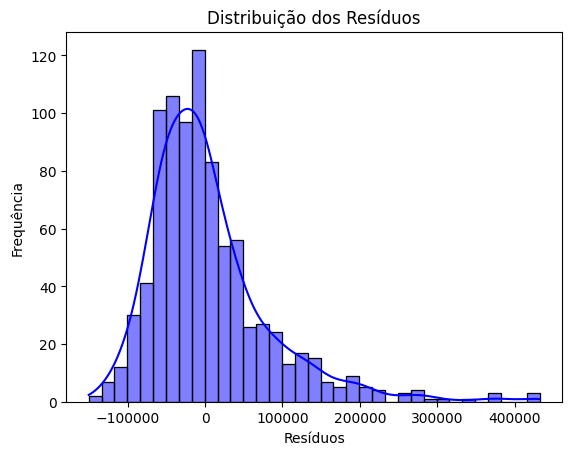

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred
sns.histplot(residuals, kde=True, color='blue')
plt.title("Distribuição dos Resíduos")
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.show()

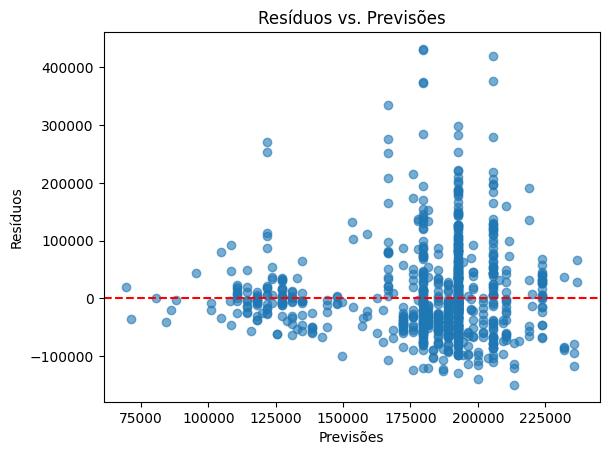

In [30]:
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos vs. Previsões")
plt.xlabel("Previsões")
plt.ylabel("Resíduos")
plt.show()

In [31]:
filtered_data['Interaction'] = filtered_data['Bedroom AbvGr'] * filtered_data['Overall Cond']

In [32]:
X = filtered_data[['Bedroom AbvGr', 'MS Zoning', 'Overall Cond', 'Interaction']]
y = filtered_data['SalePrice']

# Divisão treino/teste e ajuste do modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Reavaliar métricas
r2 = r2_score(y_test, y_pred)
print(f"R² com interação: {r2:.2f}")

R² com interação: 0.11
